In [1]:
# setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# define style do seaborn
sns.set_style('whitegrid')

In [2]:
# carrega o dataset tratado
df_br = pd.read_csv('../data/brasileirao_2014_2024_clean.csv', index_col=0)

# exibe informações sobre o dataframe
df_br.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3800 entries, 0 to 4085
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ano_campeonato          3800 non-null   int64  
 1   rodada                  3800 non-null   int64  
 2   estadio                 3800 non-null   object 
 3   publico                 3800 non-null   float64
 4   publico_max             3800 non-null   float64
 5   arbitro                 3800 non-null   object 
 6   time_mandante           3800 non-null   object 
 7   gols_mandante           3800 non-null   float64
 8   time_visitante          3800 non-null   object 
 9   gols_visitante          3800 non-null   float64
 10  escanteios_mandante     1880 non-null   float64
 11  escanteios_visitante    1880 non-null   float64
 12  faltas_mandante         1880 non-null   float64
 13  faltas_visitante        1880 non-null   float64
 14  impedimentos_mandante   1880 non-null   float

In [3]:
# define o vencedor com base nos gols e atribui "empate" se os gols forem iguais
df_br['vencedor'] = np.select(
    [df_br['gols_mandante'] > df_br['gols_visitante'], df_br['gols_mandante'] < df_br['gols_visitante']],
    [df_br['time_mandante'], df_br['time_visitante']],
    default='Empate'
)

# calcula a quantidade de pontos feitos como mandante/visitante
# vitória = 3 pontos; empate = 1 ponto; derrota = 0 pontos
df_br['pontos_mandante'] = np.select(
    [df_br['vencedor'] == df_br['time_mandante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

df_br['pontos_visitante'] = np.select(
    [df_br['vencedor'] == df_br['time_visitante'], df_br['vencedor'] == 'Empate'],
    [3, 1],
    default=0
)

# define variável de lotação dos estádios (público real / capacidade máxima)
df_br['lotacao_estadio'] = df_br['publico'] / df_br['publico_max']

In [4]:
# cálculo da taxa de aproveitamento de pontos - times mandantes/casa
aprov_mandante = (
    df_br
    .groupby(['ano_campeonato', 'time_mandante'])
    .agg(
        partidas_mandante=('pontos_mandante', 'size'),
        pontos_mandante=('pontos_mandante', 'sum')        
    )
    .assign(
        aproveitamento_mandante=lambda df: df['pontos_mandante'] / (df['partidas_mandante'] * 3)
    )
    .rename_axis(['ano_campeonato', 'time'])
    .reset_index()
)

# cálculo da taxa de aproveitamento de pontos - times visistantes/fora
aprov_visitante = (
    df_br
    .groupby(['ano_campeonato', 'time_visitante'])
    .agg(
        partidas_visitante=('pontos_visitante', 'size'),
        pontos_visitante=('pontos_visitante', 'sum')        
    )
    .assign(
        aproveitamento_visitante=lambda df: df['pontos_visitante'] / (df['partidas_visitante'] * 3)
    )
    .rename_axis(['ano_campeonato', 'time'])
    .reset_index()
)

# junção das bases de aproveitamento de pontos
df_aproveitamento = (
    aprov_mandante
    .merge(aprov_visitante, on=['ano_campeonato', 'time'])
    .assign(
        desvio_aproveitamento=lambda df: df['aproveitamento_mandante'] - df['aproveitamento_visitante']
    )
    .sort_values(by=['ano_campeonato', 'time'], ascending=True)
)

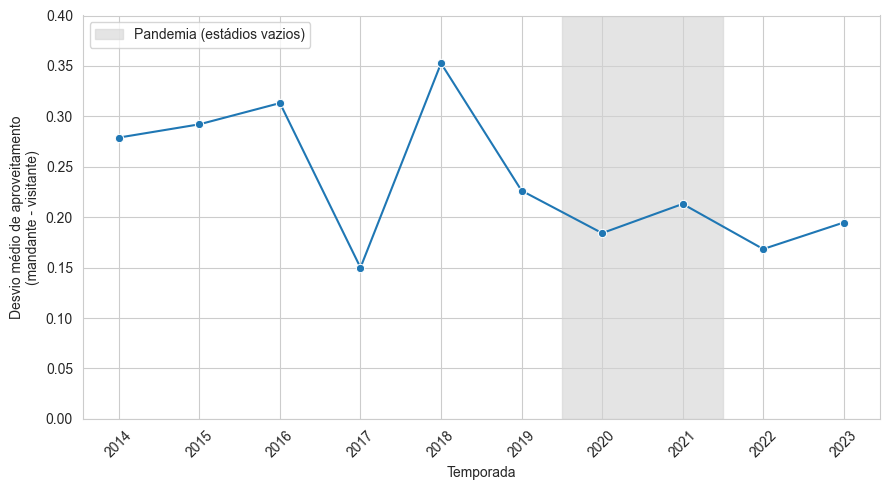

In [5]:
# check se há efeito de redução no efeito mandante durante a pandemia
# resposta curta: não parece
desvio_temporada = (
    df_aproveitamento
    .groupby('ano_campeonato')
    .agg(desvio_aproveitamento=('desvio_aproveitamento', 'mean'))
    .reset_index()
)

plt.figure(figsize=(9, 5))

sns.lineplot(
    data=desvio_temporada,
    x='ano_campeonato',
    y='desvio_aproveitamento',
    marker='o'
)

plt.axvspan(2019.5, 2021.5, color='lightgrey', alpha=0.6, label='Pandemia (estádios vazios)')
plt.legend()

plt.xlabel('Temporada')
plt.xticks(desvio_temporada['ano_campeonato'], rotation=45)
plt.ylabel('Desvio médio de aproveitamento\n(mandante - visitante)')
plt.ylim([0, 0.4])

plt.tight_layout()
plt.show()

In [6]:
(
    df_br
    .groupby('ano_campeonato')
    .agg(lotacao_estadio=('lotacao_estadio', 'mean'))
    .reset_index()
)

,ano_campeonato,lotacao_estadio
0,2014,0.391420
1,2015,0.418310
2,2016,0.387349
3,2017,0.443332
4,2018,0.453208
5,2019,0.485985
6,2020,0.000000
7,2021,0.136207
8,2022,0.494605
9,2023,0.578746
